In [1]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install torch
!pip install scikit-learn
!pip install torchvision
!pip install tqdm

In [2]:
import torch
import torch_directml
dml = torch_directml.device()
print(dml)
tensor1 = torch.tensor([1]).to(dml) # Note that dml is a variable, not a string!
tensor2 = torch.tensor([2]).to(dml)
dml_algebra = tensor1 + tensor2
print(dml_algebra.item())


privateuseone:0
3


In [3]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score
from torchvision import datasets, transforms
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, Subset
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import math
from sklearn.svm import OneClassSVM


Hyperparameters

In [4]:
class Hparams:
    def __init__(self, train_batch_size=64, test_batch_size=64, learning_rate=0.001, num_epochs=10, val_split=0.2, test_split=0.2, model_path='saved_model', dataset_path='Data'):
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.val_split = val_split
        self.test_split = test_split
        self.model_path = model_path
        self.dataset_path = dataset_path

Dataset Loader

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
            mean = torch.mean(x)
            std = torch.std(x)
        return x, mean, std, y

    def __len__(self):
        return len(self.subset)

In [6]:
def get_transforms():
    transform = transforms.Compose([
        transforms.Resize((248, 248)),
        transforms.ToTensor(),
    ])
    return transform

In [7]:
def get_transforms_train():
    transform = transforms.Compose([
        transforms.Resize((248, 248)),
        transforms.RandomAffine(0, translate=None, scale= (0.95, 1.05), shear=None),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor()
    ])
    return transform

In [8]:
def get_sample_weights(dataset, train_dataset):

    # Code taken from:
    #     https://www.maskaravivek.com/post/pytorch-weighted-random-sampler/
    y_train_indices = train_dataset.indices
    y_train = [dataset.targets[i] for i in y_train_indices]

    class_sample_counts = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

    weights = 1. / class_sample_counts
    sample_weights = np.array([weights[t] for t in y_train])
    sample_weights = torch.from_numpy(sample_weights)

    return sample_weights

In [9]:
def get_data_loaders(hparams):
    # Loading the dataset
    dataset = datasets.ImageFolder(hparams.dataset_path,
                                   transform=transforms.Compose([transforms.Grayscale()]))

    # Splitting dataset into train, validation and test partitions.
    proportions = [(1 - hparams.val_split - hparams.test_split), hparams.val_split, hparams.test_split]
    lengths = [int(p * len(dataset)) for p in proportions]
    lengths[-1] = len(dataset) - sum(lengths[:-1])
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths)

    print(f'train size: {lengths[0]}, val size: {lengths[1]}, test size: {lengths[2]}')

    data_transforms = {
        'train': get_transforms(),
        'test': get_transforms()
    }

    # Using WeightedRandomSampler to overcome unbalance problem
    sample_weights = get_sample_weights(dataset, train_dataset)
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights.type('torch.DoubleTensor'), len(sample_weights))

    train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = CustomDataset(val_dataset, transform=data_transforms['test'])
    test_dataset = CustomDataset(test_dataset, transform=data_transforms['test'])

    # Creating loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams.train_batch_size, sampler=train_sampler, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams.train_batch_size, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams.test_batch_size)
    
    return train_loader, val_loader, test_loader

In [10]:
from sklearn.model_selection import train_test_split

def get_split_dataset_loaders(hparams):

    folder_path = 'Data\\Mild Dementia'

    error = 8

    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    image_names = [file for file in file_list]

    for i in range (len(image_names)):
        image_names[i] = image_names[i][:-14]

    uniqueID = pd.Series(image_names)
    uniqueID = uniqueID.unique()

    # Proportions you want to split into (e.g., 60% train, 20% validation, 20% test)
    train_proportion = 1 - hparams.val_split - hparams.test_split
    validation_proportion = hparams.val_split
    test_proportion = hparams.test_split

    # Perform the random split
    train_ID, temp_ID = train_test_split(uniqueID, train_size=train_proportion, random_state=42)
    validation_ID, test_ID = train_test_split(temp_ID, train_size=validation_proportion / (validation_proportion + test_proportion), random_state=42)

    dataset = datasets.ImageFolder(hparams.dataset_path,
                                   transform=transforms.Compose([transforms.Grayscale()]))

    index = 0
    location_change = [0]
    for i in range(len(dataset)):
        if (dataset[i][1] != index):
            location_change.append(i)
            index += 1

    train_index = []
    for i in range (len(train_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii] and (abs(int(file_list[ii][-7:-4]) - 126) <= error)):
                train_index.append(ii+location_change[0])
            
    val_index = []
    for i in range (len(validation_ID)):
        for ii in range (len(file_list)):
            if (validation_ID[i] in file_list[ii]  and (abs(int(file_list[ii][-7:-4]) - 126) <= error)):
                val_index.append(ii+location_change[0])

    test_index = []
    for i in range (len(test_ID)):
        for ii in range (len(file_list)):
            if (test_ID[i] in file_list[ii]  and (abs(int(file_list[ii][-7:-4]) - 126) <= error)):
                test_index.append(ii+location_change[0])


    folder_path = 'Data\\Regular'

    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    image_names = [file for file in file_list]

    for i in range (len(image_names)):
        image_names[i] = image_names[i][:-14]

    uniqueID = pd.Series(image_names)
    uniqueID = uniqueID.unique()

    # Perform the random split
    train_ID, temp_ID = train_test_split(uniqueID, train_size=train_proportion, random_state=42)
    validation_ID, test_ID = train_test_split(temp_ID, train_size=validation_proportion / (validation_proportion + test_proportion), random_state=42)

    for i in range (len(train_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii] and (abs(int(file_list[ii][-7:-4]) - 126) <= error)):
                train_index.append(ii+location_change[1])
            
    for i in range (len(validation_ID)):
        for ii in range (len(file_list)):
            if (validation_ID[i] in file_list[ii]  and (abs(int(file_list[ii][-7:-4]) - 126) <= error)):
                val_index.append(ii+location_change[1])

    for i in range (len(test_ID)):
        for ii in range (len(file_list)):
            if (test_ID[i] in file_list[ii] and (abs(int(file_list[ii][-7:-4]) - 126) <= error)):
                test_index.append(ii+location_change[1])


    folder_path = 'Data\\Very mild Dementia'

    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    image_names = [file for file in file_list]

    for i in range (len(image_names)):
        image_names[i] = image_names[i][:-14]

    uniqueID = pd.Series(image_names)
    uniqueID = uniqueID.unique()

    # Perform the random split
    train_ID, temp_ID = train_test_split(uniqueID, train_size=train_proportion, random_state=42)
    validation_ID, test_ID = train_test_split(temp_ID, train_size=validation_proportion / (validation_proportion + test_proportion), random_state=42)

    for i in range (len(train_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii] and (abs(int(file_list[ii][-7:-4]) - 126) <= error)):
                train_index.append(ii+location_change[2])     

    for i in range (len(validation_ID)):
        for ii in range (len(file_list)):
            if (validation_ID[i] in file_list[ii] and (abs(int(file_list[ii][-7:-4]) - 126) <= error)):
                val_index.append(ii+location_change[2])

    for i in range (len(test_ID)):
        for ii in range (len(file_list)):
            if (test_ID[i] in file_list[ii] and (abs(int(file_list[ii][-7:-4]) - 126) <= error)):
                test_index.append(ii+location_change[2])

    train_dataset = Subset(dataset, train_index)
    val_dataset = Subset(dataset, val_index)
    test_dataset =  Subset(dataset, test_index)

    data_transforms = {
        'train': get_transforms_train(),
        'test': get_transforms()
    }

    # Using WeightedRandomSampler to overcome unbalance problem
    sample_weights = get_sample_weights(dataset, train_dataset)
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights.type('torch.DoubleTensor'), len(sample_weights))

    train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = CustomDataset(val_dataset, transform=data_transforms['test'])
    test_dataset = CustomDataset(test_dataset, transform=data_transforms['test'])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams.train_batch_size, sampler=train_sampler, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams.train_batch_size, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams.test_batch_size)

    print(check_array_overlap(train_index, val_index, test_index))

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

In [ ]:
def check_array_overlap(arr1, arr2, arr3):
    set1 = set(arr1)
    set2 = set(arr2)
    set3 = set(arr3)
    print(set1.intersection(set2))
    print(set2.intersection(set3))
    print(set3.intersection(set1))

    if set1.intersection(set2) or set1.intersection(set3) or set2.intersection(set3):
        return True
    else:
        return False

Model

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, kernel= (5,5)):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channel, mid_channel, kernel_size= kernel, padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(mid_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(mid_channel, out_channel, kernel_size= kernel, padding = 1)
        #self.conv2 = nn.Conv2d(in_channel, out_channel, kernel_size= kernel, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(out_channel)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)

        x = self.pool(x)

        return x

In [12]:
class LinearBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.fc = nn.Linear(in_channel, out_channel)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_channel)

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.batch_norm(x)

        return x

In [13]:
class LinearBlockDropout(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.fc = nn.Linear(in_channel, out_channel)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_channel)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.batch_norm(x)

        return x

In [14]:
class BayesianCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.convblock1 = ConvBlock(1, 2, 4)

        self.flatten = nn.Flatten(start_dim=1)

        self.linearblock1 = LinearBlockDropout(59536, 32)
        self.linearblock4 = LinearBlockDropout(32 + 2, 3)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, mean, std, num_samples = 5):
        predictions = torch.zeros(num_samples, x.size(0), 4).to(x.device)
        for i in range(num_samples):

            x_out = self.convblock1(x_out)

            x_out = self.flatten(x_out)

            x_out = self.linearblock1(x_out)

            x_out = torch.concat([x_out, mean.unsqueeze(1), std.unsqueeze(1)], dim=-1)
            
            mu = self.linearblock4(x_out)

            log_var = self.linearblock4.batch_norm.bias  # Get log variance from the last layer's bias
            
            x_out = self.reparameterize(mu, log_var)

            predictions[i] = x_out
            
        return self.softmax(torch.mean(predictions, dim=0))  # Use softmax on the mean prediction
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

Train and Validate Loops

In [15]:
def train(model, train_loader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    batch_size = 0

    targets, preds = [], []

    for batch_idx, (img, mean, std, target) in train_loader:
        img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
        batch_size = len(img)

        optimizer.zero_grad()
        output = model(img, mean, std)
        loss = criterion(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)

        targets.append(target.cpu().numpy())
        preds.append(pred.cpu().numpy().flatten())

        train_correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()

        train_loader.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        train_loader.set_postfix(loss=train_loss / ((batch_idx+1) * len(img)), accuracy=100. * train_correct / ((batch_idx+1) * len(img)))

    targets = np.concatenate(targets)
    preds = np.concatenate(preds)
    f1 = f1_score(targets, preds, average='macro')

    train_length = train_loader.total * batch_size
    train_loss /= train_length
    train_accuracy = 100. * train_correct / train_length
    return train_loss, train_accuracy, f1

In [16]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    val_correct = 0
    total_size = 0
    with torch.no_grad():
        for batch_idx, (img, mean, std, target) in enumerate(val_loader):
            img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            batch_size = len(img)
            output = model(img, mean, std)
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            val_correct += pred.eq(target.view_as(pred)).sum().item()

            total_size += len(img)
    val_loss /= total_size
    val_accuracy = 100. * val_correct / total_size
    return val_loss, val_accuracy

In [17]:
def predict(model, data_loader, criterion, device, eval=False):
    model.eval()
    pred_loss = 0
    pred_correct = 0
    total_size = 0

    predictions = torch.IntTensor()
    ground_truths = torch.IntTensor()

    predictions, ground_truths = predictions.to(device), ground_truths.to(device)

    with torch.no_grad():
        for batch_idx, (img, mean, std, target) in enumerate(data_loader):
            img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            output = model(img, mean, std)
            loss = criterion(output, target)
            pred_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            pred_correct += pred.eq(target.view_as(pred)).sum().item()

            predictions = torch.cat((predictions, pred), dim=0)
            ground_truths = torch.cat((ground_truths, target), dim=0)

            total_size += len(img)

    pred_loss /= total_size
    pred_accuracy = 100. * pred_correct / total_size

    if eval:
        return pred_loss, pred_accuracy, predictions.cpu().numpy(), ground_truths.cpu().numpy()
    else:
        return predictions.cpu().numpy(), ground_truths.cpu().numpy()

In [18]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, early_stopping=None):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), ascii=' >=')
        train_loss, train_accuracy, f1 = train(model, loop, criterion, optimizer, device, epoch, num_epochs)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

#        predictions, labels = predict(model, val_loader, criterion, device, eval=False)

#        conf_mat = confusion_matrix(labels, predictions)
#        class_to_idx = list(train_loader.dataset.subset.dataset.class_to_idx)
#        df_cm = pd.DataFrame(conf_mat, index = class_to_idx, columns = class_to_idx)
#        heat_map = sn.heatmap(df_cm, annot=True, fmt='', cmap='Blues')
#        plt.show()
#
#        for i in range(len(predictions)):
#            if (predictions[i] != labels[i]):
#                print(f'Image: {val_loader.dataset.subset.dataset.imgs[i][0]}, Predicted: {class_to_idx[int(predictions[i])]}, Actual: {class_to_idx[int(labels[i])]}')
        
        if early_stopping is not None:
            early_stopping(val_accuracy)

            if early_stopping.early_stop:
                tqdm.write(f'\t => train_f1={f1:.4f}, val_loss={val_loss:.4f}, val_acc={val_accuracy:.4f}')
                print(f'Early stopping at Epoch {epoch+1}')
                break

        tqdm.write(f'\t => train_f1={f1:.4f}, val_loss={val_loss:.4f}, val_acc={val_accuracy:.4f}')

    return train_losses, train_accuracies, val_losses, val_accuracies

Early Stopping

In [19]:
class EarlyStopping:
    def __init__(self, patience=5, mode='max'):
        self.counter = 0
        self.patience = patience
        self.early_stop = False
        self.mode = mode

        if self.mode == 'max':
            self.ref_value = float('-inf')
        elif self.mode == 'min':
            self.ref_value = float('inf')
        else:
            raise Exception(f'Undefined mode for EarlyStopping - mode: {mode}\n'
                             'Available modes are ["max", "min"]')

    def __call__(self, value):
        if self.mode == 'max':
            if value <= self.ref_value:
                self.counter += 1
            else:
                self.counter = 0
                self.ref_value = value
        elif self.mode == 'min':
            if value >= self.ref_value:
                self.counter += 1
            else:
                self.counter = 0
                self.ref_value = value

        if self.counter == self.patience:
            self.early_stop = True

Visualize

In [20]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [21]:
def plot_accuracies(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Training and Evaluation

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch_directml.device()
print(f"Using {device} device.")

Using privateuseone:0 device.


In [23]:
hparams = Hparams()

In [24]:
train_loader, val_loader, test_loader, train_dataset , val_dataset , test_dataset = get_split_dataset_loaders(hparams)

train size: 42974, val size: 25784, test size: 17191


In [25]:
early_stopping = EarlyStopping(patience=3, mode='max')

Training

In [26]:
model = BayesianCNN().to(device)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hparams.learning_rate)

In [28]:
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=hparams.num_epochs, early_stopping=early_stopping)

  0%|          | 0/671 [00:00<?, ?it/s]

Epoch [1/10]: 100%|==========| 671/671 [36:33<00:00,  3.27s/it, accuracy=87.7, loss=0.0153]


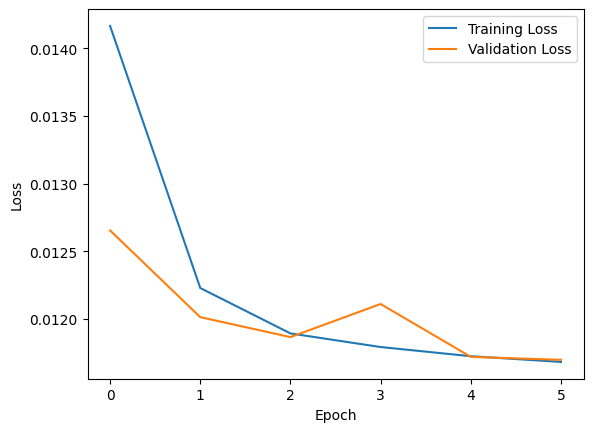

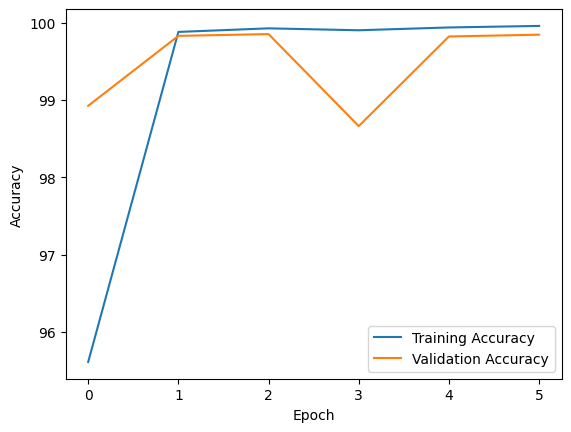

In [ ]:
plot_losses(train_losses, val_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [ ]:
def extract_features(model, data_loader):
    model.eval()
    all_features = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.cuda()
            _, features = model(inputs)
            all_features.append(features.cpu().numpy())
    return np.concatenate(all_features)

Testing

In [ ]:
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0117, Test Accuracy: 99.81%


Saving Model

In [ ]:
def save_model(model, hparams):
    os.makedirs(hparams.model_path, exist_ok=True)

    model_name = model.__class__.__name__ + '_' + datetime.now().strftime("%Y_%m_%d-%H_%M_%S" + '.pt')

    try:
        torch.save(model.state_dict(), os.path.join(hparams.model_path, model_name))
        return True
    except:
        return False

In [ ]:
save_model(model, hparams)

True

Confusion Matrix

In [ ]:
predictions, labels = predict(model, test_loader, criterion, device, eval=False)

In [ ]:
conf_mat = confusion_matrix(labels, predictions)
class_to_idx = list(train_loader.dataset.subset.dataset.class_to_idx)
df_cm = pd.DataFrame(conf_mat, index = class_to_idx, columns = class_to_idx)

<Axes: >

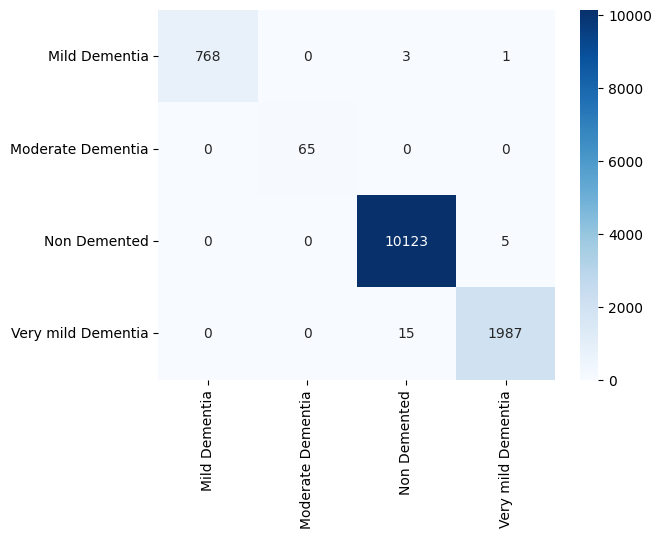

In [ ]:
sn.heatmap(df_cm, annot=True, fmt='', cmap='Blues')

Classification Report

In [ ]:
print(classification_report(labels, predictions, target_names=class_to_idx))

                    precision    recall  f1-score   support

     Mild Dementia       1.00      0.99      1.00       772
 Moderate Dementia       1.00      1.00      1.00        65
      Non Demented       1.00      1.00      1.00     10128
Very mild Dementia       1.00      0.99      0.99      2002

          accuracy                           1.00     12967
         macro avg       1.00      1.00      1.00     12967
      weighted avg       1.00      1.00      1.00     12967



OOD Detection

In [ ]:
def ood_detection_svm(model, svm_model, data_loader):
    model.eval()
    all_features = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.cuda()
            _, features = model(inputs)
            all_features.append(features.cpu().numpy())

    features = np.concatenate(all_features)
    svm_predictions = svm_model.predict(features)
    return svm_predictions

In [ ]:
def calculate_confidence(probabilities):
    return np.max(probabilities, axis=1)

def calculate_entropy(probabilities):
    return -np.sum(probabilities * np.log(probabilities), axis=1)

In [ ]:
def calculate_confidence_and_entropy(model, data_loader):
    model.eval()
    all_confidences = []
    all_entropies = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.cuda()
            _, probabilities = model(inputs)
            confidences = calculate_confidence(probabilities.cpu().numpy())
            entropies = calculate_entropy(probabilities.cpu().numpy())
            all_confidences.extend(confidences)
            all_entropies.extend(entropies)
    return np.array(all_confidences), np.array(all_entropies)

In [ ]:
# Extract features for in-distribution test data
in_distribution_features = extract_features(model, test_loader)

# Step 7: Train One-Class SVM model for OOD detection

svm_model = OneClassSVM(kernel='rbf', nu=0.1)
svm_model.fit(in_distribution_features)

In [ ]:
# Calculate confidence and uncertainty for test data
test_confidences, test_entropies = calculate_confidence_and_entropy(model, test_loader)

# Calculate confidence and uncertainty for out-of-distribution data
ood_confidences, ood_entropies = calculate_confidence_and_entropy(model, ood_loader)

# Print average confidence and uncertainty for test data
print(f"Average Confidence on Test Data: {np.mean(test_confidences):.4f}")
print(f"Average Uncertainty on Test Data: {np.mean(test_entropies):.4f}")

# Print average confidence and uncertainty for out-of-distribution data
print(f"Average Confidence on Out-of-Distribution Data: {np.mean(ood_confidences):.4f}")
print(f"Average Uncertainty on Out-of-Distribution Data: {np.mean(ood_entropies):.4f}")

# Step 10: Evaluate One-Class SVM on in-distribution and out-of-distribution datasets

# Use One-Class SVM to predict OOD samples
svm_in_distribution_predictions = ood_detection_svm(model, svm_model, test_loader)
svm_ood_predictions = ood_detection_svm(model, svm_model, ood_loader)

# Print the number of in-distribution and out-of-distribution samples
print(f"In-distribution samples: {np.sum(svm_in_distribution_predictions == 1)}")
print(f"Out-of-distribution samples: {np.sum(svm_ood_predictions == -1)}")